### Exercise 1: Classification with US Airline Sentiment Tweets

##### Import the libraries necessary for this project.

In [15]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from gensim.models import CoherenceModel

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### 1. Data Preprocessing & Exploratory Data Analysis (EDA)

##### Load the Tweets dataset and print 5 first rows to get an overview.

In [2]:
tweets_df = pd.read_csv("datasets/Tweets.csv", encoding="utf-8")
tweets_df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


##### Check the quality of some texts by printing 5 random rows.

In [3]:
tweets_df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12123,570282469791911936,positive,0.6710,NaN,NaN,American,NaN,mrespinosa1971,NaN,0,@AmericanAir - keeping AA up in the Air! My cr...,NaN,2015-02-24 10:01:50 -0800,Great State of Texas,Central Time (US & Canada)
6115,568214541852495872,neutral,1.0000,NaN,NaN,Southwest,NaN,cosmicghoul,NaN,0,@SouthwestAir i cant look up my confirmation n...,NaN,2015-02-18 17:04:38 -0800,they/them,Pacific Time (US & Canada)
8950,567727329783582720,positive,1.0000,NaN,NaN,Delta,NaN,JessonaJourney,NaN,0,@JetBlue Thank you!,NaN,2015-02-17 08:48:37 -0800,New York,Eastern Time (US & Canada)
364,568476562376531969,neutral,0.6696,NaN,NaN,Virgin America,NaN,CuteMonsterDad,NaN,0,@virginamerica Digging the swanky pink mood li...,NaN,2015-02-19 10:25:48 -0800,3rd Planet from the Sun,Central Time (US & Canada)
8337,568474096058507264,neutral,0.6659,NaN,NaN,Delta,NaN,lyteforce,NaN,0,@JetBlue Just looking to arrange for a nice fl...,NaN,2015-02-19 10:16:00 -0800,Richmond BC,Pacific Time (US & Canada)


##### Checks the sum of NaN values.

In [4]:
tweets_df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

##### Create remove_unwanted function to remove mentions (@user), hashtags (#hashtag), URLs and emojis with regex patterns. We handle them because we want to keep the important context.

In [5]:
def remove_unwanted(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    emojis = re.compile(
        "[\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]", flags=re.UNICODE
    )
    text = emojis.sub(r'', text)
    return text

##### Call remove_unwanted, lowercase text, lemmatize, remove stopwords and return preprocessed texts. Punctuation can influence the meaning of sentences so we keep them for sentiment analysis.

In [6]:
def preprocessing(sentence):
    sentence = remove_unwanted(sentence)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence, language='english', preserve_line=True)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = " ".join(filtered_tokens)
    return filtered_tokens

tokens = [preprocessing(sentence) for sentence in tweets_df['text']]
tweets_df['text'] = [" ".join(token) for token in tokens]
tweets_df['text']

0                                                   said .
1         plus 've added commercial experience ... tacky .
2         n't today ... must mean need take another trip !
3        's really aggressive blast obnoxious `` entert...
4                                  's really big bad thing
                               ...                        
14635                 thank got different flight chicago .
14636    leaving 20 minute late flight. warning communi...
14637                        please bring american airline
14638    money , change flight , n't answer phone ! sug...
14639    8 ppl need 2 know many seat next flight. plz p...
Name: text, Length: 14640, dtype: object

##### Compute sentence lengths and plot the distribution of sentence lengths.

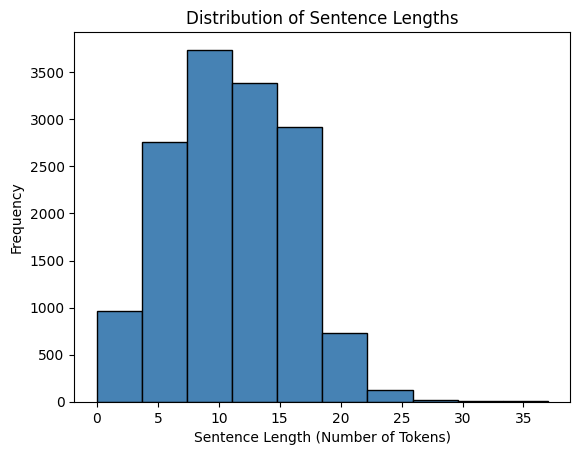

In [7]:
sentence_lengths = []
for token in tokens:
    sentence_lengths.append(len(token))

plt.hist(sentence_lengths, color='steelblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (Number of Tokens)')
plt.ylabel('Frequency')
plt.show()

##### Plot top 10 most frequent words and characters with a bar plot.

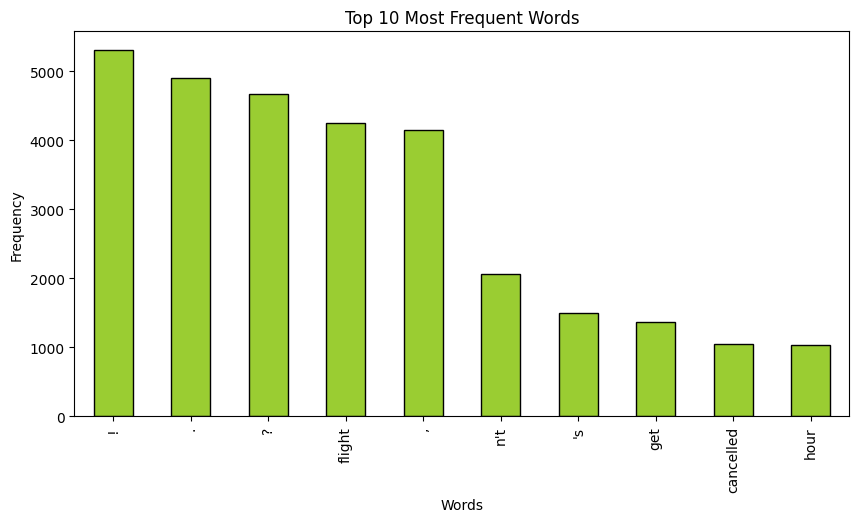

In [40]:
word_freq = pd.Series([word for words in tokens for word in words]).value_counts()
word_freq.head(10).plot(kind='bar', figsize=(10, 5), color='yellowgreen', edgecolor='black')
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

##### Perform advanced EDA by creating word cloud to explore word frequency.

(-0.5, 799.5, 399.5, -0.5)

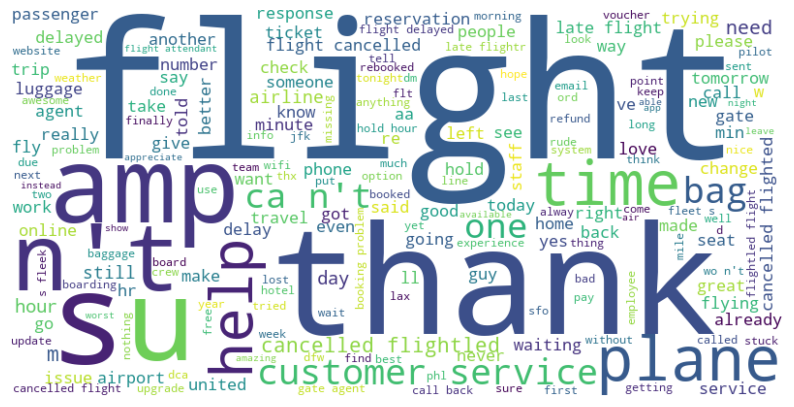

In [8]:
k= (' '.join(tweets_df['text']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(k)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

##### Create a corpus from the filtered data, select the number of topics and train the Lda-model.

In [18]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets_df['text'])
corpus = Sparse2Corpus(X, documents_columns=False)
id2word = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}
num_topics = 2
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=10)
for topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(topic)

(0, '0.064*"flight" + 0.018*"cancelled" + 0.016*"hour" + 0.013*"get" + 0.010*"plane" + 0.010*"hold" + 0.009*"flightled" + 0.008*"bag" + 0.008*"still" + 0.008*"time"')
(1, '0.013*"customer" + 0.013*"call" + 0.012*"service" + 0.012*"thanks" + 0.010*"help" + 0.009*"get" + 0.009*"phone" + 0.009*"please" + 0.007*"thank" + 0.007*"ca"')


#### 2. Feature Extraction (Vectorization)

#### 3. Build the ANN Classifier

#### 4. Performance Metrics

#### 5. Visualization